<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Лемматизация-и-очистка-текста" data-toc-modified-id="Лемматизация-и-очистка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Лемматизация и очистка текста</a></span></li><li><span><a href="#Эмбеддинги от Bert"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Эмбеддинги от Bert</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#CatBoostClassifier" data-toc-modified-id="CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CatBoostClassifier</a></span></li><li><span><a href="#Тестирование лучшей модели" data-toc-modified-id="Тестирование лучшей модели"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Тестирование лучшей модели</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# импорт библиотек

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip3 install transformers
!pip3 install torch
!pip install catboost

import re # Регулярные выражения
import torch # PyTorch
import transformers # для инициализации токенизатора, объект класса BertTokenizer() и прочие
from tqdm import notebook # индикатор прогресса
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.tree import DecisionTreeClassifier # дерево-классификатор
from sklearn.model_selection import cross_val_score # cv
from sklearn.model_selection import train_test_split # разбика выборок
from sklearn.model_selection import RandomizedSearchCV # подбор гиперпараметров и cv
from sklearn.metrics import f1_score # F1

import nltk # NLP инструменты
from nltk.corpus import stopwords # списки стоп-слов
nltk.download('stopwords') # загрузили списко стоп-слов
from sklearn.feature_extraction.text import TfidfVectorizer # импорт TF-IDF
from sklearn.feature_extraction.text import CountVectorizer # импорт bow

from transformers import AutoTokenizer, AutoModelForMaskedLM # ваниант вместо Bert


from catboost import CatBoostClassifier # классификатор
from sklearn.utils.class_weight import compute_class_weight # чтобы посчитать балланс классов для Catbo

nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer # лемматайзер
from transformers import BertTokenizer, BertModel # импорт BertTokenizer и model

from nltk import word_tokenize # токенайзер
nltk.download('punkt') # пунктуация для токенайзер 
nltk.download('averaged_perceptron_tagger') # POSS tagg из коробки

!pip install wordcloud # библиотека для облака тегов
from wordcloud import WordCloud # библиотека для облака тегов

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
stop_words = set(stopwords.words('english')) # пометили, что на английском стоп-слова
count_tf_idf = TfidfVectorizer(stop_words=list(stop_words)) # счетчик TF-IDF 
count_vect = CountVectorizer(stop_words=list(stop_words)) # счетчик bow

In [ ]:
# список паттернов маскировки ругательных слов на анг

RE_PATTERNS = {' american ': ['amerikan'], ' adolf ': ['adolf'], ' hitler ': ['hitler', 'shitler'],
                       ' fuck': ['(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
                                 '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)', ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k',
                                 'f u u c', '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*', 'feck ', ' fux ', 'f\*\*', 'f\-ing',
                                 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck', 'wtf'],
                       ' ass ': ['[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$', '[^a-z]anus', ' a\*s\*s',
                                 '[^a-z]ass[^a-z ]', 'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'],
                       ' ass hole ': [' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole'],
                       ' bitch ': ['b[w]*i[t]*ch', 'b!tch', 'bi\+ch', 'b!\+ch',
                                   '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)', 'biatch', 'bi\*\*h', 'bytch',
                                   'b i t c h'], ' bastard ': ['ba[s|z]+t[e|a]+rd'], ' trans gender': ['transgender'],
                       ' gay ': ['gay'],
                       ' cock ': ['[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
                                  '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'],
                       ' dick ': [' dick[^aeiou]', 'deek', 'd i c k', 'dihck'],
                       ' suck ': ['sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'],
                       ' cunt ': ['cunt', 'c u n t'], ' bull shit ': ['bullsh\*t', 'bull\$hit'],
                       ' homo sex ual': ['homosexual'], ' jerk ': ['jerk'],
                       ' idiot ': ['i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots',
                                   'i d i o t'], ' dumb ': ['(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'],
                       ' shit ': ['shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', 
                                  'bull shit', 'shit bull'],
                       ' shit hole ': ['shythole'], ' retard ': ['returd', 'retad', 'retard', 'wiktard', 'wikitud'],
                       ' rape ': [' raped'], ' dumb ass': ['dumbass', 'dubass'], ' ass head': ['butthead'],
                       ' sex ': ['sexy', 's3x', 'sexuality'],
                       ' nigger ': ['nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r', 'nihgga'],
                       ' shut the fuck up': ['stfu'], ' pussy ': ['pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'],
                       ' faggot ': ['faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
                                    '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot',
                                    'fae[g]+ot', ],
                       ' mother fucker': [' motha ', ' motha f', ' mother f', 'motherucker', ],
                       ' whore ': ['wh\*\*\*', 'w h o r e', 'hoe'] }

In [3]:
# импорт данных

try:
    df = pd.read_csv(r"C:\Users\plotn\My_python_stuff\toxic_comments.csv")
except:
    df = pd.read_csv(r"/datasets/toxic_comments.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
# посмотрим
display(df.sample(10))

,Unnamed: 0,text,toxic
113734,113832,"I tried using YukataNinja's wording, but it di...",0
72426,72497,The project is being repeatedly vandalised and...,0
42126,42176,Bravo on all your criticisms about this film. ...,0
22172,22192,You LOVE Anime!? There are some ANIMES out the...,1
97680,97774,"""\nA tag has been placed on Le Khanh Giang, re...",0
11102,11115,I really can't see the point of opening an RFC...,0
31297,31337,IS A FASCIST BULLY CONSTANTLY ATTEMPTING TO FO...,1
147968,148124,I basically want someone of brown appearance f...,0
14751,14767,DreamGuy\nI've already promised Ed that I will...,1
79827,79903,"""\n\nI will think about what you said. I remo...",0


In [6]:
# удалим ненужный столбец
df = df.drop(['Unnamed: 0'],axis=1)

In [7]:
print(round((df[df['toxic'] == 1]['text'].shape[0]/df.shape[0]),2)*100, '% доля токсичных комментариев в датафрейме')
print(round((df[df['toxic'] == 0]['text'].shape[0]/df.shape[0]),2)*100, '% доля обычных комментариев в датафрейме')

10.0 % доля токсичных комментариев в датафрейме
90.0 % доля обычных комментариев в датафрейме


Токсичных комментариев почти в 10 раз меньше, потребуется балансировка классов.

### Лемматизация и очистка текста

In [8]:
# создадим лемматизиатор объект класса WordNetLemmatizer object
wnl = WordNetLemmatizer()

In [10]:
# функция для очистки

def clear_text(text):
    text = text.lower()
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    for target, patterns in RE_PATTERNS.items():
        for pat in patterns:
            text = re.sub(pat, target, text)
    
    cl_text = re.sub(r'[^a-zA-Z]', ' ', text).split()
    cl_text = " ".join(cl_text)
    
    return cl_text

In [11]:
# функция для Poss используется ниже

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# функция для лемматизации (wnl.lemmatize())
    
def lemmatize(text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:	
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(wnl.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    
    return lemmatized_sentence

### Эмбеддинги от Bert

In [12]:
# выделим df c 1600 записями с теми же долями токсичных и не-токсичных комментариев, что в общейм df 

df_2, df_1600 = train_test_split(df, test_size=0.011, random_state=12345, stratify=df['toxic'])

In [13]:
del df_2

In [14]:
df_1600.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1753 entries, 158851 to 44009
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1753 non-null   object
 1   toxic   1753 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 41.1+ KB


In [15]:
print(df_1600[df_1600['toxic'] == 1]['text'].shape[0], 'токсичных комментариев в датафрейме c 1600 записями')
print(df_1600[df_1600['toxic'] == 0]['text'].shape[0], 'обычных комментариев в датафрейме c 1600 записями')

178 токсичных комментариев в датафрейме c 1600 записями
1575 обычных комментариев в датафрейме c 1600 записями


In [16]:
# почистим текст
df_1600['cln_text'] = notebook.tqdm(df_1600['text'].apply(clear_text))

  0%|          | 0/1753 [00:00<?, ?it/s]

/tmp/ipykernel_293/2384991077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1600['cln_text'] = notebook.tqdm(df_1600['text'].apply(clear_text))


In [17]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [18]:
# лемматизируем
notebook.tqdm.pandas()

df_1600['lemm_text'] = df_1600['cln_text'].progress_apply(lemmatize)

  0%|          | 0/1753 [00:00<?, ?it/s]

/tmp/ipykernel_293/2617897528.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1600['lemm_text'] = df_1600['cln_text'].progress_apply(lemmatize)


In [19]:
# посмотрим на токсичные комментарии

display(df_1600[df_1600['toxic'] == 1].sample(10))

,text,toxic,cln_text,lemm_text
75139,"""\n\n D€ATH TO NORWEGIANS AND ALL ANTI-SEℳITES...",1,d ath to norwegians and all anti se ites who s...,d ath to norwegian and all anti se ites who si...
51539,"Hm, your edit deleted the explanation of where...",1,hm your edit deleted the explanation of where ...,hm your edit delete the explanation of where i...
35751,...and I don't take non-footnoted and bullshit...,1,and i do not take non footnoted and shit entri...,and i do not take non footnote and shit entry ...
117263,Hi \n\nyou're my little b1tsch,1,hi you are my little b tsch,hi you be my little b tsch
134297,U SUCK COCK U IDIOTS!!!!!!!!!!!!!!!!,1,u suck cock u idiot s,u suck cock u idiot s
92420,""" \n\nFirst off, I really don't think that's n...",1,first off i really do not think that is needed...,first off i really do not think that be need o...
24516,YOU'RE A SAD ARSEHOLE. GET A LIFE.,1,you are a sad arsehole get a life,you be a sad arsehole get a life
48719,Hey! \n\nWhy the fuck did you have your talk p...,1,hey why the fuck did you have your talk page s...,hey why the fuck do you have your talk page se...
60691,You and Jack greenmaven are MotherFuckers,1,you and jack greenmaven are mother fuck,you and jack greenmaven be mother fuck
63252,bilcat mom is a dumpster slutt,1,bilcat mom is a dumpster slutt,bilcat mom be a dumpster slutt


In [102]:
toxic_text = ' '.join(df_1600[df_1600['toxic'] == 1]['lemm_text'])

In [104]:
non_toxic_text = ' '.join(df_1600[df_1600['toxic'] == 0]['lemm_text'])

(-0.5, 399.5, 199.5, -0.5)

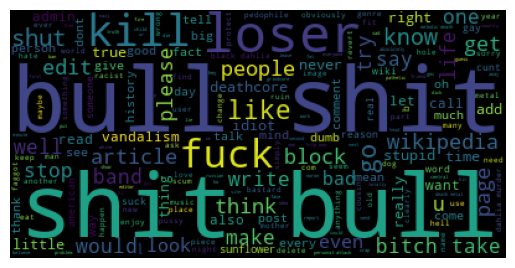

In [103]:
cloud = WordCloud(stopwords=stop_words).generate(toxic_text)
plt.imshow(cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

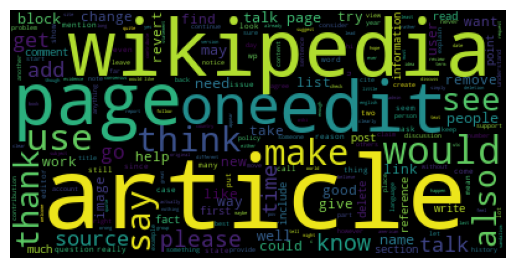

In [105]:
cloud = WordCloud(stopwords=stop_words).generate(non_toxic_text)
plt.imshow(cloud)
plt.axis('off')

In [53]:
# удалим лишние столбцы
df_1600 = df_1600.drop(['text', 'cln_text'],axis=1)

In [51]:
# удалим исходный df, чтобы он не занимал оперативную память
del df

In [54]:
df_1600

,toxic,lemm_text
158851,0,i will edit and add something to this too in a...
89161,0,eat to live vs live to eat be definetely an un...
53501,0,break stuff do you really break thing when you...
137172,0,i will be discuss use of the internet with all...
66948,0,merge proposal i have add a merge proposal on ...
...,...,...
117812,0,i revert both of you because both of you have ...
82537,1,but the real question be why be that noteworth...
104973,0,no i be commit no copyright violation as not o...
133349,0,unfortunately i disagree with you here when yo...


In [56]:
# инициализировали токенайзер BertTokenizer() со словарем токенов (vocab.txt) 
tokenizer = BertTokenizer.from_pretrained("unitary/toxic-bert")

C:\Users\plotn\anaconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\plotn\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [57]:
# создали предобученную модель Берта, обученную на токсичных комментариях 
model = BertModel.from_pretrained("unitary/toxic-bert")

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
# токенизируем по образцу из теории бадчами

tokenized = df_1600['lemm_text'].apply(
    lambda x: tokenizer.encode(x, max_length=512, truncation=True, add_special_tokens=True))

In [61]:
display(tokenized.head())
print(tokenized.shape)

158851    [101, 1045, 2097, 10086, 1998, 5587, 2242, 200...
89161     [101, 4521, 2000, 2444, 5443, 2444, 2000, 4521...
53501     [101, 3338, 4933, 2079, 2017, 2428, 3338, 2518...
137172    [101, 1045, 2097, 2022, 6848, 2224, 1997, 1996...
66948     [101, 13590, 6378, 1045, 2031, 5587, 1037, 135...
Name: lemm_text, dtype: object

(1753,)


In [62]:
# максимальная длинна для дистилята Берта
max_len = 512

# пээдинг (отступ с 0), чтобы длинна всех твитов была равна длинне максимального 
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

In [63]:
# маска внимания только для тех значений векторов, которые не 0
attention_mask = np.where(padded != 0, 1, 0)

In [64]:
# бадчами взяли эмбеддинги из предобученной модели с тензорами
# batch_size+1 - чтобы последняя не целая часть бадча тоже пошла 


batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size+1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/18 [00:00<?, ?it/s]

In [65]:
features = np.concatenate(embeddings)


In [69]:
display(features)
print(features.shape)

array([[-0.43496376, -0.78333014,  0.8378801 , ..., -0.9760757 ,
         0.86210483,  0.4281185 ],
       [-0.46306038, -0.92187315,  0.20899445, ..., -0.64136356,
         0.77140385,  0.34157267],
       [-0.3383191 , -0.724756  ,  0.8462917 , ..., -0.81338745,
         0.7425335 ,  0.33906326],
       ...,
       [-0.38755152, -0.57941693,  0.7639511 , ..., -1.0343515 ,
         0.6879391 ,  0.4108202 ],
       [-0.60019577, -0.75662446,  0.49076343, ..., -0.8846253 ,
         0.5846179 ,  0.18085144],
       [-0.46617576, -0.96910393,  0.6245164 , ..., -0.71848863,
         0.7882419 ,  0.31430247]], dtype=float32)

(1753, 768)


In [76]:
# разбили на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            df_1600['toxic'], 
                                                                            test_size=0.25, 
                                                                            random_state=12345, 
                                                                            stratify= df_1600['toxic'])

## Обучение моделей

### LogisticRegression

In [77]:
model_1 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

In [78]:
scores = cross_val_score(model_1, features_train, target_train, cv=10, scoring='f1') 
final_score = sum(scores)/len(scores) 

print('Средняя f1 линейной регрессии c баллансом классов:', round((final_score),2))

Средняя f1 линейной регрессии c баллансом классов: 0.86


In [79]:
for i in scores:
    print(i)


0.8799999999999999
0.8750000000000001
0.8387096774193549
0.962962962962963
0.7741935483870968
0.7692307692307693
0.896551724137931
0.8799999999999999
0.7586206896551724
0.9285714285714286


### RandomForestClassifier

In [81]:
from sklearn.ensemble import RandomForestClassifier

In [82]:
model_2 =  RandomForestClassifier(class_weight='balanced')

parameters_2 = { 'n_estimators': range (10, 101, 10),
               'max_depth': range (1,11, 1) }

In [83]:
r_search = RandomizedSearchCV(model_2,
                             param_distributions=parameters_2,
                             scoring='f1',
                             n_jobs=-1,
                             cv=3,
                             n_iter=100,
                             random_state=12345)

In [84]:
r_search.fit(features_train, target_train)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 11),
                                        'n_estimators': range(10, 101, 10)},
                   random_state=12345, scoring='f1')

In [86]:
print('средняя f1 леса c баллансом классов на трейне', round((r_search.best_score_),2))

средняя f1 леса c баллансом классов на трейне 0.91


### CatBoostClassifier

In [88]:
# балланс классов для catboost 

classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

model_3 = CatBoostClassifier(loss_function="Logloss", class_weights=class_weights, verbose=100)


In [89]:
parameters_3 = { 'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'depth': [2, 3],
                'n_estimators': [10, 50, 100, 500, 1000] 
               }

In [90]:
r_search_3 = RandomizedSearchCV(model_3,
                             param_distributions=parameters_3,
                             scoring='f1',
                             n_jobs=-1,
                             cv=3,
                             n_iter=100,
                             random_state=12345)

In [91]:
r_search_3.fit(features_train, target_train)

C:\Users\plotn\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 50 is smaller than n_iter=100. Running 50 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\plotn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\plotn\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\plotn\anaconda3\lib\site-packages\catboost\core.py", l

0:	learn: 0.2859498	total: 192ms	remaining: 19s
99:	learn: 0.0032589	total: 1.53s	remaining: 0us


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000020F212E4D30>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'depth': [2, 3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'n_estimators': [10, 50, 100, 500,
                                                         1000]},
                   random_state=12345, scoring='f1')

In [92]:
print('средняя f1 CatBoostClassifier c баллансом классов на трейне', round((r_search_3.best_score_),2))

средняя f1 CatBoostClassifier c баллансом классов на трейне 0.87


**Лучшая модель - RandomForestClassifier с баллансом классов со средним f1 на обучающей выборке 0.91.**

### Тестирование лучшей модели

In [95]:
model_2 =  RandomForestClassifier(class_weight='balanced', **r_search.best_params_)
model_2.fit(features_train, target_train)
print("f1 лучшей модели на тестовой выборке", round((f1_score(target_test, model_2.predict(features_test))),2))

f1 лучшей модели на тестовой выборке 0.84


## Выводы

Модель классифицирующая комментарии на позитивные и негативные и отрицательные обучена. f1 модели на тестовой выборке 0.84.
<br><br>
Много оперативной памяти требуется, чтобы использовать предобученную модель Bert. Качество итоговой модели сильно зависит от того, на каком датасете обучена модель, из которой берутся эмбеддинги. Результат Bert обученного на токсичных и не-токсичных комментариях выше, чем у дистиллята Bert.    